In [4]:
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns

In [5]:
import sys
sys.path.append('../') # go to parent dir
sys.path.append('/home/artem/git/sdafe-utils')

In [6]:
from sdafe.ch05.mle import mle_se
from sdafe.ch07.multivariate import fit_mvt, loglik_mvt, cov_trob

### 7.13.1 Equity Returns

In [7]:
data = pd.read_csv('../data/berndtInvest.csv', index_col=0, parse_dates=[0])
data.head()

,CITCRP,CONED,CONTIL,DATGEN,DEC,DELTA,GENMIL,GERBER,IBM,MARKET,MOBIL,PANAM,PSNH,TANDY,TEXACO,WEYER,RKFREE
X.Y..m..d,,,,,,,,,,,,,,,,,
1978-01-01,-0.115,-0.079,-0.129,-0.084,-0.100,-0.028,-0.099,-0.048,-0.029,-0.045,-0.046,0.025,-0.008,-0.075,-0.054,-0.116,0.00487
1978-02-01,-0.019,-0.003,0.037,-0.097,-0.063,-0.033,0.018,0.160,-0.043,0.010,-0.017,-0.073,-0.025,-0.004,-0.010,-0.135,0.00494
1978-03-01,0.059,0.022,0.003,0.063,0.010,0.070,-0.023,-0.036,-0.063,0.050,0.049,0.184,0.026,0.124,0.015,0.084,0.00526
1978-04-01,0.127,-0.005,0.180,0.179,0.165,0.150,0.046,0.004,0.130,0.063,0.077,0.089,-0.008,0.055,0.000,0.144,0.00491
1978-05-01,0.005,-0.014,0.061,0.052,0.038,-0.031,0.063,0.046,-0.018,0.067,-0.011,0.082,0.019,0.176,-0.029,-0.031,0.00513


In [8]:
ret = data.iloc[:, :4]

In [9]:
ret.cov()

,CITCRP,CONED,CONTIL,DATGEN
CITCRP,0.006556,0.001093,0.006052,0.005509
CONED,0.001093,0.002527,0.000795,0.000612
CONTIL,0.006052,0.000795,0.022710,0.005050
DATGEN,0.005509,0.000612,0.005050,0.016266


In [10]:
ret.corr()

,CITCRP,CONED,CONTIL,DATGEN
CITCRP,1.000000,0.268590,0.495983,0.533458
CONED,0.268590,1.000000,0.104999,0.095524
CONTIL,0.495983,0.104999,1.000000,0.262758
DATGEN,0.533458,0.095524,0.262758,1.000000


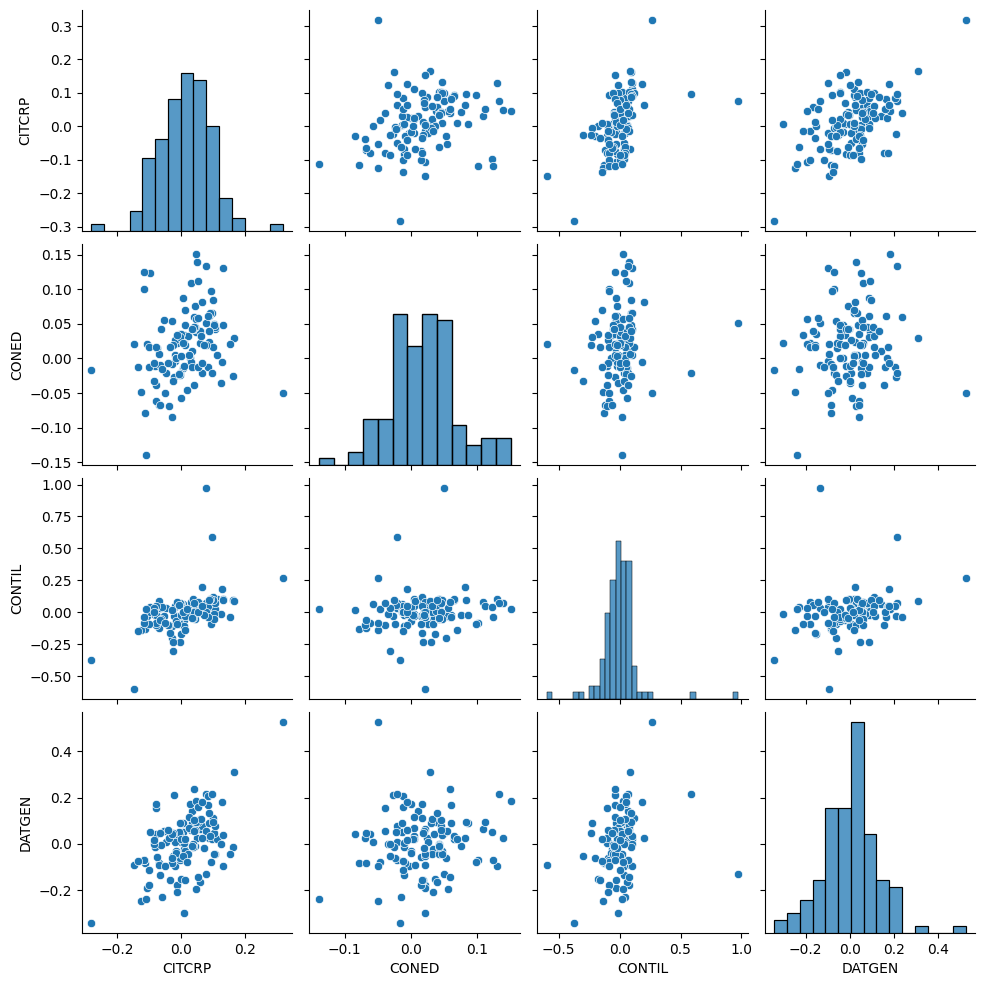

In [11]:
sns.pairplot(ret);

#### Problem 1

In [12]:
w = np.array([0.5, 0.3, 0.2, 0.0])

In [13]:
w @ ret.cov() @ w

0.0044088647366946785

In [15]:
df = np.linspace(2.5, 8.0, math.floor((8.0 - 2.5) / 0.01) + 1)
n = len(df)
loglik_profile = np.zeros(n)
for i in range(n):
    fit = cov_trob(ret.values, nu=df[i])
    mu = fit['center']
    sigma = fit['cov']
    loglik_profile[i] = np.sum(np.log(stats.multivariate_t.pdf(ret.values, loc=mu, shape=sigma, df=df[i])))

The MLE of $\nu$ is:

In [16]:
df[np.argmax(loglik_profile)]

4.55

The 90% confidence interval is:

In [17]:
conf = 0.9

In [18]:
l, h = np.arange(len(loglik_profile))[loglik_profile > np.max(loglik_profile) - stats.chi2.ppf(conf, df=1) / 2][[0, -1]]

In [19]:
df[[l, h]]

array([3.23, 6.59])

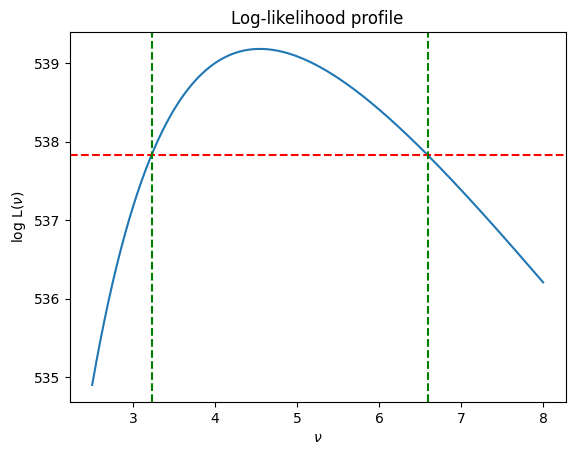

In [20]:
fig, ax = plt.subplots()
ax.plot(df, loglik_profile)
ax.set_xlabel('$\\nu$')
ax.set_ylabel('log L($\\nu$)')
ax.set_title('Log-likelihood profile')
ax.axhline(np.max(loglik_profile) - stats.chi2.ppf(conf, df=1) / 2, color='red', linestyle='--')
ax.axvline(df[l], color='green', linestyle='--')
ax.axvline(df[h], color='green', linestyle='--');

### 7.13.2 Simulating Multivariate t-Distributions

In [21]:
N = 2500
nu = 3

#### Problems 3-5

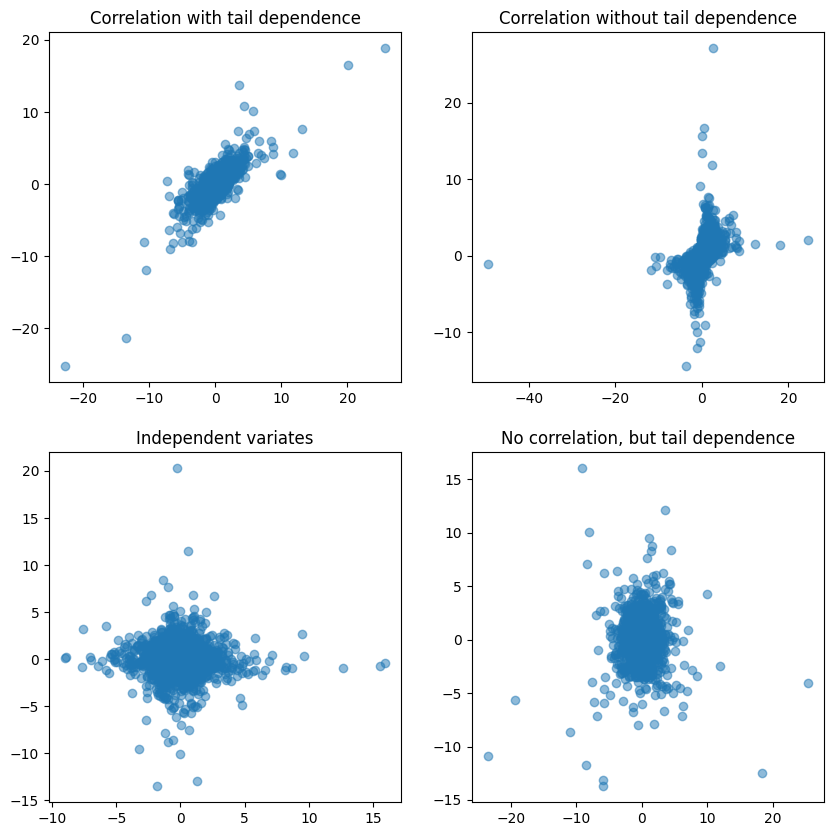

In [22]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10));

cov = np.array([
    [1.0, 0.8],
    [0.8, 1.0],
])

# correlation + tail dependence
rng = np.random.default_rng(seed=12345)
x = stats.multivariate_normal.rvs(size=N, mean=np.array([0, 0]), cov=cov, random_state=rng)
w = np.sqrt(nu / stats.chi2.rvs(size=(N, 1), df=nu, random_state=rng))
x = x * w

axs[0, 0].scatter(x[:, 0], x[:, 1], alpha=0.5)
axs[0, 0].set_title('Correlation with tail dependence');

# correlation, but no tail dependence
ng = np.random.default_rng(seed=12345)
x = stats.multivariate_normal.rvs(size=N, mean=np.array([0, 0]), cov=cov, random_state=rng)
w1 = np.sqrt(nu / stats.chi2.rvs(size=(N, 1), df=nu, random_state=rng))
w2 = np.sqrt(nu / stats.chi2.rvs(size=(N, 1), df=nu, random_state=rng))
x = x * np.hstack([w1, w2])

axs[0, 1].scatter(x[:, 0], x[:, 1], alpha=0.5)
axs[0, 1].set_title('Correlation without tail dependence');

# no correlation, no tail dependence
ng = np.random.default_rng(seed=12345)
cov = np.array([[1.0, 0.0], [0.0, 1.0]])
x = stats.multivariate_normal.rvs(size=N, mean=np.array([0, 0]), cov=cov, random_state=rng)
w1 = np.sqrt(nu / stats.chi2.rvs(size=(N, 1), df=nu, random_state=rng))
w2 = np.sqrt(nu / stats.chi2.rvs(size=(N, 1), df=nu, random_state=rng))
x = x * np.hstack([w1, w2])

axs[1, 0].scatter(x[:, 0], x[:, 1], alpha=0.5)
axs[1, 0].set_title('Independent variates');

# no correlation, no tail dependence
rng = np.random.default_rng(seed=12345)
x = stats.multivariate_normal.rvs(size=N, mean=np.array([0, 0]), cov=cov, random_state=rng)
w = np.sqrt(nu / stats.chi2.rvs(size=(N, 1), df=nu, random_state=rng))
x = x * w

axs[1, 1].scatter(x[:, 0], x[:, 1], alpha=0.5)
axs[1, 1].set_title('No correlation, but tail dependence');

#### Problem 6

In [23]:
nu = 5
mu = np.array([0.001, 0.002])
sigma = np.array([
    [0.10, 0.03],
    [0.03, 0.15],
])

(a) The return of the portfolio has a univarite t-distribution with mean

In [24]:
w = np.array([0.5, 0.5])

In [25]:
mu_R = np.sum(w * mu)
mu_R

0.0015

and variance

In [26]:
sigma_R = w @ sigma @ w
sigma_R

0.0775

(b)

In [27]:
N = 10000

In [28]:
rng = np.random.default_rng(12345)
x1 = stats.t.rvs(size=N, loc=mu_R, scale=np.sqrt(sigma_R), df=nu, random_state=rng)
x2 = stats.multivariate_normal.rvs(size=N, mean=mu, cov=sigma, random_state=rng) @ w

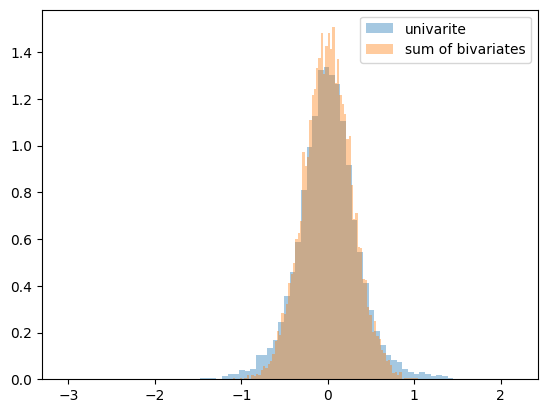

In [29]:
fig, ax = plt.subplots()
ax.hist(x1, bins=80, density=True, label='univarite', alpha=0.4);
ax.hist(x2, bins=80, density=True, label='sum of bivariates', alpha=0.4);
ax.legend();

It is interesting to observe that the univarite sample appears to have fatter tails.

The upper 0.01 quantile is:

In [30]:
alpha = 0.01
q = np.quantile(x1, 1-alpha)
q

0.9736492621357973

The average of returns exceeding the upper 0.01 quantile is:

In [31]:
np.mean(x1[x1 > q])

1.2502330179575414

#### Problem 7

In [32]:
data = pd.read_csv('../data/CRSPday.csv', usecols=[1, 2, 3, 4, 5, 6, 7], parse_dates=[[0, 1, 2]], index_col=0)
data.head()

,ge,ibm,mobil,crsp
year_month_day,,,,
1989-01-03,-0.016760,0.000000,-0.002747,-0.007619
1989-01-04,0.017045,0.005128,0.005510,0.013016
1989-01-05,-0.002793,-0.002041,0.005479,0.002815
1989-01-06,0.000000,-0.006135,0.002725,0.003064
1989-01-09,0.000000,0.004115,0.005435,0.001633


In [33]:
Y = data[['ge', 'mobil']]

In [34]:
fit_t = fit_mvt(Y, mu_bounds=(-0.02, 0.02), a_bounds=(-0.1, 0.1), df_bounds=(2, 15))
fit_t

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: -14947.412318606703
        x: [ 8.970e-04  5.706e-04  1.135e-02  3.118e-03  1.022e-02
             6.426e+00]
      nit: 18
      jac: [ 1.359e+00  1.007e+00  1.009e+00  4.156e-01  4.293e-01
             2.001e-03]
     nfev: 154
     njev: 22
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>

(a) It performs Cholesky decomposition to find an upper-triangular matrix $M$, such that $M'M = A$.

(b) The estimate of the parameter vector is:

In [35]:
fit_t.x

array([8.97034972e-04, 5.70605148e-04, 1.13509923e-02, 3.11805089e-03,
       1.02202445e-02, 6.42647230e+00])

(c) and (d)

In [36]:
mle_se(fit_t.x, lambda par: loglik_mvt(Y, par))

array([2.51571193e-04, 2.36603548e-04, 2.21732159e-04, 2.33408230e-04,
       2.00261355e-04, 5.45185957e-01])

(e) The MLE of the covariance matrix is:

In [37]:
A = np.array([[fit_t.x[2], fit_t.x[3]], [0, fit_t.x[4]]])
Sigma = A.T @ A
Sigma

array([[1.28845027e-04, 3.53929718e-05],
       [3.53929718e-05, 1.14175640e-04]])

(f) The MLE of the correlation between the two returns is:

In [38]:
sigma_inv = (1 / np.sqrt(np.diag(Sigma))).reshape(-1, 1)
sigma_inv * Sigma * sigma_inv.T

array([[1.        , 0.29180751],
       [0.29180751, 1.        ]])